<a href="https://colab.research.google.com/github/Seb125/MFCC_Genres/blob/main/Genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Genre classification using mfcc's

In this notebook I want to classify music from 10 different genres. The input data is the GTZAN Dataset (https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification), which contains 100 30s exerpts for 10 diffenrent genres. For each exerpt mfcc vectors are calculated, which are used as input data for the machine learning algorithms. 

The mapping of the labels:
       0: "hiphop",
       1: "blues",
       2: "rock",
       3: "jazz",
       4: "disco",
       5: "metal",
       6:"classical",
       7: "pop",
       8: "country",
       9: "reggae"

In [ ]:
import os
import librosa
import math
import json

DATASET_PATH = "Genres"
JSON_PATH = "data.json"

SAMPLE_RATE = 22050
DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION


# json_path: path to the file where we store all mfccs and the labels
# each track is chopped into 10 segments

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    
    # dictionary to store data
    data = {
      "mapping": [], # classical is mapped to indice 0
      "mfcc": [], # mfccs for each segment
      "labels":[]  # target (first segment is classical, second, classical....)

    }
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # esnure that we're not at the root/dataset level
        if dirpath is not dataset_path:   #dirpath gives path of current directory
            
            # save the semantic label
            dirpath_components = dirpath.split("/") # genre/blues => ["genre", "blues"]
            semantic_label = dirpath_components[-1]  # last entry of dirpath_components
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))

            # process files for a specific genre
            for f in filenames:
                
                #load audio file
                file_path = os.path.join(dirpath, f)
                print(file_path)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                
                # process segments extracting mfcc and storing data
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s # s = 0 -> 0
                    finish_sample = start_sample + num_samples_per_segment # s = 0 -> num_samples_per_segment

          
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                      sr=sr,
                                                      n_fft=n_fft,
                                                      n_mfcc=n_mfcc,
                                                      hop_length=hop_length)
                    
                    mfcc = mfcc.T  # transpose -> mfcc vectors are columns
                    
                    
                    # store mfcc for segment if it has the expected length
                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1) # cause the first iteration is at the root level
                        print("{}, segment:{}".format(file_path, s))
   
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

## Trying different classifiers (MLP, SVM, KNN) on the flattened feature vectors

In [1]:
import json
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score


DATASET_PATH = "data10.json"  # Here I import a smaller version of the GTZAN Dataset with 10 songs per genre

def load_data(dataset_path):
    with open(dataset_path, "r") as fp: # r = read
        data = json.load(fp)
        
    # convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets


In [2]:
#load data
inputs, targets = load_data(DATASET_PATH)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3)

### Flattening and Normalizing Input vectors

In [3]:
from sklearn.preprocessing import StandardScaler

# Reshape inputs: Inputs have 3 dimensions (0:segments, 1:mfcc windows in each segment, 2:mff vectors)
# for each segment we concatenate all mfcc vectors

# inputs_train.shape = (699, 130, 13) inputs_train_reshaped.shape = (699, 1690)
X_train_reshaped = X_train.reshape(699,1690)
# inputs_train.shape = (300, 130, 13) inputs_train_reshaped.shape = (300, 1690)
X_test_reshaped = X_test.reshape(300,1690)

# normalizing input features
X_train = StandardScaler().fit_transform(X_train_reshaped)
X_test = StandardScaler().fit_transform(X_test_reshaped)

# Kernel methods (https://bloom.bg/2ui2T4q)

## Motivation

Mapping from an input space $\chi$ to a vector in $R^d$ is called feature extraction.  
Feature mapping is a function of the form $\psi: \chi -> R^d$.  
To get expressive hypothesis spaces using linear models we need high-dimensional feature spaces. Suppose we start with $x= (1, x_1, ..., x_d) \in R^{d+1} = \chi$. Now with our feature mapping $\psi(x)$ we want all monomials of degree M. Then we will end up with the number of features of $O(d^M)$?. Thus we will get extremely large matrices. Having large feature spaces have two problems, Overfitting (handled by regularization) and memory, computational cost. Kernel methods can (sometimes) help with memory and computational costs.


###### Definition

A method can be kernalized if inputs appear inside inner products: $\langle  \; \psi(x), \psi(x') \; \rangle$ for $x, x' \in \chi$.  
The kernel function corresponding to such an inner product is:  

$k(x,x') = \langle  \; \psi(x), \psi(x') \; \rangle$.  

Kernels as similarity scores: It is often useful to think of the kernel function as a similarity score. The final classifier is a similarity-weighted vote (see section... for details). However this is not a mathematically precise statement.



###### Different Kernels

###### Linear Kernel

Feature map: $\phi(x)  = x$  
Kernel: $k(x, x') = x^Tx'$

A linear kernel uses just the original input features. The output of the linear kernel function just gives the standard dot product between two data points $x^Tx'$. As x and x' lie in the original input space,w e don't get acces to a higher dimensional feature space by using a lienar kernel. We are using the original feature space and the kernel function does not has any computational benefits. So if our input vector already lie in high dimensional feature space, such that the data is already seperable with a linear method, I won't get any benefit form using kernel methods.(?)

###### Quadratic Kernel

Input space $\chi = R^d$  
Feature space: $H = R^D$, where $D = d + \binom{d}{2} \approx \frac{d^2}{2}$.

Feature map: 

$\psi(x) = (x_1,...,x_d,x^2_1,...x^2_d,\sqrt{2}x_1x_2,...,\sqrt{2}x_{d-1}x_d)^T$

Then for $\forall x, x' \in R^d$

$k(x,x') = \langle  \; \psi(x), \psi(x') \; \rangle = \langle  \; x, x' \; \rangle + \langle  \; x, x' \; \rangle ^2$

Computation for inner product with explicit mapping: $O(d^2)$  
Computation for implicit kernel calculation: $O(d)$.

Thus with the qudratic kernel function we can evaluate a dot product of feature space that includes all monomials up to degree 2 of the original input space, while computation cost is in the same order as for the original feature space. Notice that we have these extra coefficients ($\sqrt{2}$) in front of our features. These interact with our regularization. We can use smaller coefficients $w$ to get the same output, such that with regularization these features get favored by the model.

###### Polynomial Kernel

Input space $\chi = R^d$  
Kernel function:  

$k(x,x') = (1 + \langle  \; x, x' \; \rangle)^M$
    
Corresponds to a feature map with all monomials up to degree M.  
For any M, computing the kernel has same computationsl cost.  
Cost of explicit inner product computation grows rapidly in M. 

###### RBF/Gaussian Kernel

Input space $\chi = R^d$   
Kernel function:  

$k(x,x') = exp(-\frac{||x-x'||^2}{2\sigma^2})$ 

where $\sigma^2$ is known as the bandwith parameter. 

Does it act like a similarity score?:
For $x=x'$ the kernel evaluates to 1 and for increasing distance between x and x' the value of the functions gets closer to 0.  
Why "radial"?: The output is independent of orientation. All x's in the same radius of x get the same similarity score.  
For the RBF kernel we have in some sense departed form our "inner product of feature vector" recipe. The RBF kernel corresponds to an infinite dimensional feature vector ($\psi(x)$ has infinite number of dimensions). 
It is probably the most common nonlinear kernel. 
How does the kernel function behave if we change $\sigma^2$?:....see UCSD lecture slides!

###### The Kernel trick

We can transform certain objektive functions into a kernalized version (see details below). This kernalized objective function contains the kernel matrix.

For points $x_1,...,x_n \in \chi$ and an inner product $\langle  \; .,. \; \rangle$ on $\chi$, the kernel matrix is defined as:  

$K = (\langle  \; x_i, x_j \; \rangle)_{ij} = \left(\begin{array}{rrr} 
\langle  \; x_1, x_1 \; \rangle & ... & \langle  \; x_1, x_n \; \rangle \\ 
... & ... & ... \\ 
\langle  \; x_n, x_1 \; \rangle & ... & \langle  \; x_n, x_n \; \rangle \\ 
\end{array}\right) = XX^T$  

which is an $nxn$ matrix. 

Given a kernalized ML algorithm, we can swap out the kernel function. The new kernel may correspond to a high dimensional feature space. Once the kernel matrix is computed , the computational cost depends only on the number of data points, rather than the dimesnion of the feature space. 

In ridge regression we deel with a matrix $X^TX$ which is $dxd$. In general you would prefer to work with the smaller matrix. Thus kernel methods are prefered when $n<<d$.

Swapping out a linear kernel for a new kernel is called the kernel trick.


### How to kernalize an objective function

#### Generalized objective function

Featurized SVM objective:

$min_{w\in R^d} \frac{1}{2} ||w||^2 + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i[\langle  \; w, \psi(x_i) \; \rangle])$

Generalized objective:

$min_{w\in H}  R(||w||) + L(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$,

where

$R: R^{>=0} -> R$ in nondecreasing (Regularization term)  
$L: R^n -> R$ is arbitrary (Loss term)   
with Hilbert space $H$, typically $H = R^d$

Ridge regression and SVM are of this form.  
Lasso regression is not of this form, as $l_1$ does not correspond to an inner product (Why is this important? see section....).

#### Representer Theorem

Let $min_{w\in H}  R(||w||) + L(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$.

If J(w) has a minimizer, then it has a minimizer of the form $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$. Thus $w^*$ lies in the span of the data; is a linear combination of the featurized input vectors.

Proof

Let w be a minimizer  
Let $M = span(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$  
Let $w^*= Proj_M w$. So $\exists$ s.t. $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$  
$w^*$ lives in $R^d$ but it lives also in M, which is a subspace of $R^d$ of dimension n.  
$w^{\bot} := w - w^*$ is orthogonal to M.  
Projections decrease norms: $||w^*|| \leq ||w||$  
Since R is nondecreasing, $R(||w^*||) \leq R(||w||)$  

$\langle  \; w, \psi(x_i) \; \rangle = \langle  \; w^* + w - w^*, \psi(x_i) \; \rangle = \langle  \; w^* + w^{\bot}, \psi(x_i) \; \rangle = \langle  \; w^*, \psi(x_i) \; \rangle + \langle  \; w^{\bot}, \psi(x_i) \; \rangle
= \langle  \; w^*, \psi(x_i) \; \rangle$  

So $L(\langle  \; w, \psi(x_i) \; \rangle) = L(\langle  \; w^*, \psi(x_i) \; \rangle)$  

$J(w^*) \leq J(w)$

Therefore $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$ is also a minimizer.


#### Kernalized predictions

Consider $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$ (In he following w is used, but I refer to $w^*$ as described in the representer theorem).  

How do we make predictions for a given $x \in \chi$?  

$f(x) = \langle  \; w, \psi(x) \; \rangle = \langle  \; \Sigma_{i=1}^{n} \alpha_i \psi(x_i), \psi(x) \; \rangle = \Sigma_{i=1}^{n} \alpha_i \langle  \; \psi(x_i), \psi(x) \; \rangle = \Sigma_{i=1}^{n} \alpha_i k(x_ix)$

Predictions on training points $x_1$ to $x_n$:  

$ \left(\begin{array}{r} 
f(x_1) \\ 
... \\ 
f(x_n)\\ 
\end{array}\right) = \left(\begin{array}{r} 
\Sigma_{i=1}^{n} \alpha_i k(x_ix_1) \\ 
... \\ 
\Sigma_{i=1}^{n} \alpha_i k(x_ix_n)\\ 
\end{array}\right)= \left(\begin{array}{r} 
\alpha_1k(x_1x_1) + ... + \alpha_nk(x_1x_n) \\ 
... \\ 
\alpha_1k(x_nx_1) + ... + \alpha_nk(x_nx_n)\\ 
\end{array}\right) = \left(\begin{array}{r} 
k(x_1x_1) + ... + k(x_1x_n) \\ 
... \\ 
k(x_nx_1) + ... + k(x_nx_n)\\ 
\end{array}\right) \left(\begin{array}{r} 
\alpha_1\\ 
... \\ 
\alpha_n\\ 
\end{array}\right) = K\alpha$  

Note: f(x) is a linear combination of $k(x_1,x),...,k(x_n,x)$, all considered functions of x.  


#### Kernalized regularization

Consider $w = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$. What does $R(||w||)$ look like?  

$||w||^2 = \langle  \; w, w \; \rangle = \langle  \; \Sigma_{i=1}^{n} \alpha_i \psi(x_i), \Sigma_{i=1}^{n} \alpha_i \psi(x_i) \; \rangle = \Sigma_{i,j=1}^{n} \alpha_i \alpha_j \langle  \; \psi(x_i), \psi(x_j) \; \rangle = \Sigma_{i,j=1}^{n} \alpha_i \alpha_j k(x_i,x_j) = \alpha^TK\alpha$

This is a quadratic form.

#### Now we can kernalize some objective functions

##### Kernalize SVM

The SVM objective:  

$min_{w\in R^d} \frac{1}{2} ||w||^2 + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i[\langle  \; w, \psi(x_i) \; \rangle])$

Kernelizing yields:

$min_{\alpha\in R^n} \frac{1}{2} \alpha^TK\alpha + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i(K\alpha)_i)$

SVM work very nicely with kernalizations, as many $\alpha's$ are equal to 0. So not all n datapoints are needed for a prediction.

##### Kernalize Ridge Regression

Featurized ridge regression

$min_{w\in R^d} \frac{1}{n} \Sigma_{i=1}^{n} (\langle  \; w, \psi(x_i) \; \rangle - y_i)^2 + \lambda ||w||^2$

Kernalized ridge Regression:

$min_{\alpha\in R^n} \frac{1}{n} ||K\alpha - y||^2 + \lambda\alpha^TK\alpha$

## Returning to the classification task
Input data:

In [5]:
X_train.shape

(699, 1690)

For each 10s segment we had 130 mfcc vectors. After flattening the data we get a 1690 dimensional vector for each of the 699 10s segments. As described above, kernalzing an objective function can give you access to high dimensional feature spaces. For a polynomail kernel of degree 3 for example, the featurized input vector is of order $O(d^3)$. For our 1690 dimensional feature vectors this results in a dimension of the order $10^9$. 
Is such a large feature space a reasonable choice? Overfitting should not be a problem as long as we use regularization. With such a large feature space we probably can generate a quite expressive model, while the computational cost is reduced by the kernalization, as the number of data points is comparatively very low (see above). SVM's can be kernalized. Also, as many $\alpha's$ are 0 (this can be seen by optimizing the dual objective of a SVM), such that not all n data points are needed for making predictions. Therefore SVM's with different kernels are used in the following to classify the songs into 10 different genres.

### SVM with different kernels (linear, poly, rbf) and  flattened mfcc input vectors

Using 5 fold Cross Validation to tune C value of SVM

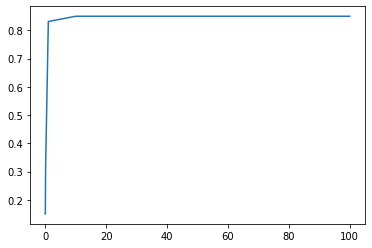

Choice of C:  10.0
Cross-validation accuracy score estimate:  0.8498136645962733


In [4]:
c_values = [0.001,0.01,0.1,1.0,10.0,100.0]

acc_scores_rbf = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'rbf')
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    m = scores.mean()
    acc_scores_rbf.append(m)
    
index_max = max(range(len(acc_scores_rbf)), key=acc_scores_rbf.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_rbf)
plt.show()
h, s = c_values[index_max], max(acc_scores_rbf)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [19]:
clf_rbf = svm.SVC(C=10, kernel = 'rbf')
clf_rbf.fit(X_train, y_train)
y_pred = clf_rbf.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

1.0

In [20]:
y_pred = clf_rbf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8433333333333334

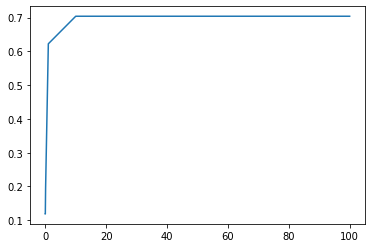

Choice of C:  10.0
Cross-validation accuracy score estimate:  0.703874614594039


In [7]:
c_values = [0.001,0.01,0.1,1.0,10.0,100.0]

acc_scores_poly = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'poly')
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    m = scores.mean()
    acc_scores_poly.append(m)
    
index_max = max(range(len(acc_scores_poly)), key=acc_scores_poly.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_poly)
plt.show()
h, s = c_values[index_max], max(acc_scores_poly)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [21]:
clf_poly = svm.SVC(C=10, kernel = 'poly')
clf_poly.fit(X_train, y_train)
y_pred = clf_poly.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

1.0

In [22]:
y_pred = clf_poly.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.72

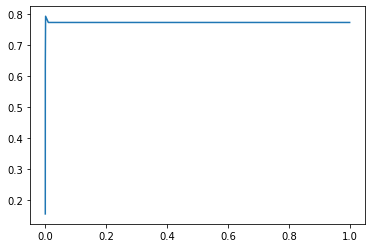

Choice of C:  0.001
Cross-validation accuracy score estimate:  0.7925899280575539


In [10]:
c_values = [0.00001,0.0001,0.001,0.01,0.1,1]

acc_scores_linear = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'linear')
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    m = scores.mean()
    acc_scores_linear.append(m)
    
index_max = max(range(len(acc_scores_linear)), key=acc_scores_linear.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_linear)
plt.show()
h, s = c_values[index_max], max(acc_scores_linear)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [23]:
clf_linear = svm.SVC(C=0.001, kernel = 'linear')
clf_linear.fit(X_train, y_train)
y_pred = clf_linear.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

0.9628040057224606

In [24]:
y_pred = clf_linear.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7766666666666666

# Neural network (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

c_values = [0.001,0.01,0.1,1.0,10.0,100.0]

acc_scores_linear = []
for c in c_values:
    
    clf = MLPClassifier(solver='adam', alpha=c,
                 hidden_layer_sizes=(512, 256, 64),activation='relu', random_state=1)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    m = scores.mean()
    acc_scores_linear.append(m)
    
index_max = max(range(len(acc_scores_linear)), key=acc_scores_linear.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_linear)
plt.show()
h, s = c_values[index_max], max(acc_scores_linear)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [6]:
1e-5

1e-05

In [25]:
from sklearn.neural_network import MLPClassifier

clf_mlp = MLPClassifier(solver='adam', alpha=0.0001,
                 hidden_layer_sizes=(512, 256, 64),activation='relu', random_state=1, max_iter = 200)

clf_mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(512, 256, 64), random_state=1)

In [26]:
y_pred = clf_mlp.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

1.0

In [28]:
y_pred_mlp = clf_mlp.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8166666666666667

#### Zero Information baseline model



In [22]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([65, 76, 69, 68, 66, 75, 70, 68, 71, 71]))

The second genre seems to be the most frequent genre in the training data set. This is the class we will always predict for the test set.

In [23]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([35, 24, 31, 32, 34, 25, 30, 32, 28, 29]))

In [24]:
24/len(y_test)

0.08

The zero information model gets an accuracy of 8% in the test set.

## Confusion matrix, precision, recall, ROC

In [29]:
metrics.confusion_matrix(y_test, y_pred_mlp)

array([[24,  2,  0,  0,  0,  1,  0,  0,  0,  1],
       [ 0, 16,  1,  4,  0,  0,  0,  2,  0,  5],
       [ 0,  0, 23,  1,  0,  1,  0,  0,  0,  2],
       [ 0,  1,  1, 27,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0, 30,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  0,  0, 28,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0, 34,  0,  0,  1],
       [ 0,  0,  0,  2,  0,  0,  0, 24,  1,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  5, 23,  0],
       [ 3,  6,  5,  0,  0,  2,  0,  0,  0, 16]])

The row in the confusion matrix corresponds to the true label and the column corresponds to the predicted label. It seems that the genres 2 (Blues) and 10 (Reggae) were hard to separate. The classifier predicted Blues 6 times, when the actual label was Reggae and predicted Reggae 5 times when the actual label was Blues.

### Precision Recall, ROC curves for multiclass predictions

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

n_classes = 10

Y_train = label_binarize(y_train, classes=[*range(n_classes)])
Y_test = label_binarize(y_test, classes=[*range(n_classes)])


clf = OneVsRestClassifier(MLPClassifier(solver='adam', alpha=0.0001,
                 hidden_layer_sizes=(512, 256, 64),activation='relu', random_state=1, max_iter = 200))

clf.fit(X_train, Y_train)

y_score = clf.predict_proba(X_test)

### Plot precision recall curves for the multiclass problem

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

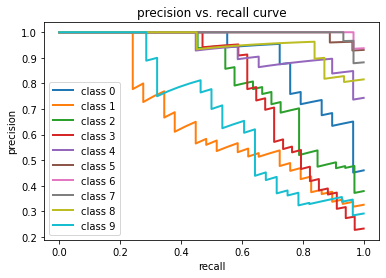

In [7]:

# precision recall curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()


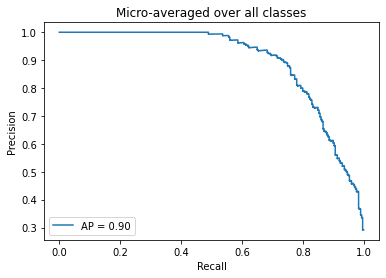

In [8]:
from sklearn.metrics import PrecisionRecallDisplay

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")


display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")


AP = Average Precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight

0: "hiphop", 1: "blues", 2: "rock", 3: "jazz", 4: "disco", 5: "metal", 6:"classical", 7: "pop", 8: "country", 9: "reggae"

The precision recall curves vary quite a lot between different genres. For Metal and Classical music Precision stays very high as the threshold is lowered and Recall is increasing. On the other hand for Reaggea and Blues Precision quickly deteriorates with decreasing threshold. This is in line with the confusion matrix above, which showed difficulties to separate Reggea and Blues.

### Plot ROC curves for the multiclass problem

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

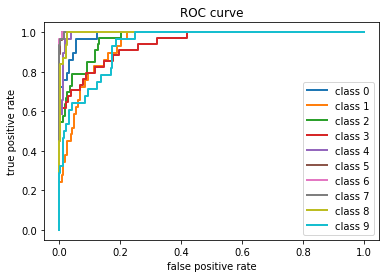

In [12]:
from sklearn.metrics import auc

# roc curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i],
                                  y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

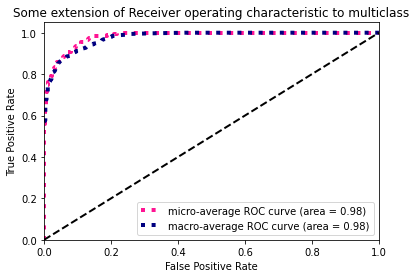

In [14]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

## Comparing average Precision Recall curves between classifiers

In [20]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize

n_classes = 10

Y_train = label_binarize(y_train, classes=[*range(n_classes)])
Y_test = label_binarize(y_test, classes=[*range(n_classes)])

# Creating One vs Rest Classifier (Is this specail case or default option for SVM?)
# MLP
clf_mlp = OneVsRestClassifier(MLPClassifier(solver='adam', alpha=0.0001,
                 hidden_layer_sizes=(512, 256, 64),activation='relu', random_state=1, max_iter = 200))

clf_mlp.fit(X_train, Y_train)

y_score_mlp = clf_mlp.predict_proba(X_test)

print("Done with CLF1")

#Poly SVM
clf_poly = OneVsRestClassifier(svm.SVC(C=10, kernel = 'poly'))

clf_poly.fit(X_train, Y_train)

y_score_poly = clf_poly.decision_function(X_test)

print("Done with CLF2")

#Rbf SVM

clf_rbf = OneVsRestClassifier(svm.SVC(C=10, kernel = 'rbf'))

clf_rbf.fit(X_train, Y_train)

y_score_rbf = clf_rbf.decision_function(X_test)

print("Done with CLF3")

#Linear SVM

clf_linear = OneVsRestClassifier(svm.SVC(C=0.001, kernel = 'linear'))

clf_linear.fit(X_train, Y_train)

y_score_linear = clf_linear.decision_function(X_test)

print("Done with CLF4")

Done with CLF1
Done with CLF2
Done with CLF3
Done with CLF4


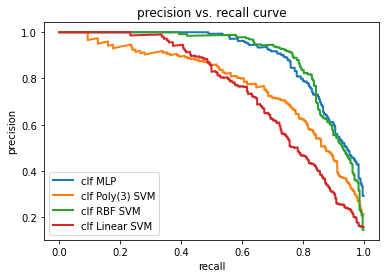

AP-MLP = 0.8975620231845116
AP-Poly = 0.7822079922025026
AP-RBF = 0.8974509037613123
AP-Linear = 0.7524831870820686


In [28]:
# Average precision recall curves of all 4 classifiers

clf_names = ["MLP", "Poly(3) SVM", "RBF SVM", "Linear SVM"]
clf_scores = [y_score_mlp, y_score_poly, y_score_rbf, y_score_linear]
precision = dict()
recall = dict()
average_precision = dict()

for i in range(4):
    # A "micro-average": quantifying score on all classes jointly
    precision["micro" + str(i)], recall["micro" + str(i)], _ = precision_recall_curve(Y_test.ravel(), clf_scores[i].ravel())
    
    average_precision["micro" + str(i)] = average_precision_score(Y_test, clf_scores[i], average="micro")

    plt.plot(recall["micro" + str(i)], precision["micro" + str(i)], lw=2, label='clf {}'.format(clf_names[i]))


plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

print("AP-MLP = " + str(average_precision["micro" + str(0)]))
print("AP-Poly = " + str(average_precision["micro" + str(1)]))
print("AP-RBF = " + str(average_precision["micro" + str(2)]))
print("AP-Linear = " + str(average_precision["micro" + str(3)]))

Performance on training set:

Not surprisingly the more complex the model (in terms of the size of the feature space and using higher order monomials), the higher the accuracy is on the training data. For the rbf and the poly kernel we get 100% accuracy and for the linear model still around 97%.

Performance on test set:

Highest accuracy is obtained with the rbf kernel. This is again not surprising to me, as this kernel gives access to an infinite feature space. Also with the reagularization term, overfitting should not be an issue.

Interestingely the linear model performs better on the test set than using the poly kernel of degree 3. 
Polynomial decision boundaries are more expressive then linear decision boundaries. Still the linear decision bundary could be closer to the true decision boundary, thus performing better on the test set.
Also, we don't have a lot training points, maybe with more data the polynomial boundary would perform better. 

All three models perform way better than a 0 information baseline model. Its surprising that genres can be seperated so well just based on spectral information of the soundfiles. 

In [15]:
clf = svm.SVC(C=0.1, kernel = 'poly')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.16666666666666666

In [21]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([65, 76, 69, 68, 66, 75, 70, 68, 71, 71]))

In [17]:
y_test

array([1, 7, 5, 2, 6, 8, 0, 3, 4, 6, 4, 9, 1, 5, 9, 5, 1, 7, 7, 6, 5, 6,
       6, 2, 0, 8, 2, 1, 0, 0, 6, 4, 7, 0, 8, 0, 9, 2, 4, 1, 8, 4, 8, 0,
       3, 0, 5, 6, 2, 2, 5, 3, 7, 6, 9, 5, 0, 9, 3, 2, 4, 8, 0, 7, 0, 0,
       9, 7, 6, 2, 5, 7, 9, 8, 0, 8, 9, 1, 2, 4, 3, 8, 3, 9, 3, 2, 6, 7,
       4, 8, 5, 8, 2, 6, 9, 3, 7, 1, 9, 5, 8, 0, 2, 3, 6, 0, 7, 6, 4, 1,
       4, 9, 8, 4, 4, 2, 9, 3, 3, 3, 2, 0, 2, 4, 3, 7, 3, 5, 6, 4, 4, 6,
       5, 2, 8, 4, 6, 6, 7, 7, 8, 7, 4, 0, 1, 6, 4, 3, 9, 3, 6, 5, 0, 8,
       0, 3, 4, 7, 6, 5, 4, 0, 6, 1, 9, 6, 9, 2, 9, 3, 4, 9, 2, 0, 5, 7,
       5, 2, 3, 4, 0, 9, 7, 2, 0, 4, 2, 9, 5, 8, 1, 8, 5, 7, 3, 0, 1, 0,
       3, 6, 7, 0, 8, 7, 4, 7, 2, 6, 1, 8, 0, 0, 7, 6, 9, 7, 5, 7, 4, 9,
       7, 3, 9, 6, 0, 1, 7, 4, 3, 3, 8, 1, 3, 7, 0, 9, 3, 3, 0, 9, 2, 1,
       4, 5, 6, 2, 1, 2, 5, 1, 5, 9, 0, 7, 3, 2, 3, 3, 2, 5, 0, 9, 8, 5,
       4, 4, 2, 4, 8, 4, 0, 4, 8, 9, 7, 2, 0, 8, 6, 2, 7, 3, 6, 9, 1, 1,
       1, 8, 3, 1, 1, 1, 5, 6, 7, 8, 2, 8, 4, 4])